在程序开发中，map、filter、zip 可以说是非常常见了，下面来从源码的角度分析一下它们的实现原理。首先需要说明的是，**这几个不是函数，而是类。**

### map

map 是将一个序列中的每个元素都作用于同一个函数（类、方法也可以），当然，我们知道调用 map 的时候并没有马上执行，而是返回一个 map 对象。既然是对象，那么底层必有相关的定义。

解释一下里面的字段含义：

**1.PyObject_HEAD：**见过很多次了，它是任何对象都会有的头部信息。包含一个引用计数 ob_refcnt、和一个指向类型对象的指针 ob_type；

**2.iters：**一个指向 PyTupleObject 的指针。以 map(lambda x: x + 1, [1, 2, 3]) 为例，那么这里的 iters 就相当于是 ([1, 2, 3].\__iter__(),)。至于为什么，分析源码的时候就知道了；

**3.func：**显然就是函数指针了，PyFunctionObject *；

通过底层结构体定义，我们也可以得知在调用 map 时并没有真正的执行；对于函数和可迭代对象，只是维护了两个指针去指向它。
而一个 PyObject 占用 16 字节，再加上两个 8 字节的指针总共 32 字节。**因此在 64 位机器上，任何一个 map 对象所占大小都是 32 字节。**

In [1]:
numbers = list(range(100000))
strings = ["abc", "def"]

# 都占32字节
print(map(lambda x: x * 3, numbers).__sizeof__()) 
print(map(lambda x: x * 3, strings).__sizeof__())

32
32


再来看看 map 的用法，Python 中的 map 不仅可以作用于一个序列，还可以作用于任意多个序列。

map 还可以接收任意多个可迭代对象

In [4]:
m1 = map(
    lambda x: x[0] + x[1] + x[2],
    [(1, 2, 3), (4, 5, 6), (7, 8, 9)]
)
print(list(m1))

m2 = map(
    lambda x, y, z: x + y + z,
    [1, 2, 3], [4, 5, 6], [7, 8, 9]
)
print(list(m2))

[6, 15, 24]
[12, 15, 18]


In [5]:
# 我们说 map 的第一个参数是一个函数，后面可以接收任意多个可迭代对象
# 但是注意: 可迭代对象的数量 和 函数的参数个数 一定要匹配
m3 = map(
    lambda x, y, z: str(x) + y + z,
    [1, 2, 3], ["a", "b", "c"], "abc"
)
print(list(m3))

# 但是可迭代对象之间的元素个数不要求相等，会以最短的为准
m3 = map(
    lambda x, y, z: str(x) + y + z,
    [1, 2, 3], ["a", "b", "c"], "ab"
)
print(list(m3))

['1aa', '2bb', '3cc']
['1aa', '2bb']


所以 map 会将后面所有可迭代对象中的每一个元素按照顺序依次取出，然后传递到函数中，**因此 函数的参数个数 和 可迭代对象的个数 一定要相等。**



那么map对象在底层是如何创建的呢？很简单，因为map是一个类，那么调用的时候一定会执行里面的 \__new__ 方法。



所以我们看到**map_new 做的工作很简单，就是实例化一个 map 对象，然后对内部的成员进行赋值**。我们用 Python 来模拟一下上述过程：



In [6]:
class MyMap:

    def __new__(cls, *args, **kwargs):
        if kwargs:
            raise TypeError("MyMap不接收关键字参数")
        numargs = len(args)
        if numargs < 2:
            raise TypeError("MyMap至少接收两个参数")
        # 元组内部的元素不可以改变(除非本地修改)，所以这里使用列表来模拟
        # 创建一个长度为 numargs - 1 的列表，元素都是None，模拟C中的NULL
        iters = [None] * (numargs - 1)  
        i = 1
        while i < numargs:  # 逐步循环
            it = iter(args[i])  # 获取可迭代对象，得到其迭代器
            iters[i - 1] = it  # 设置在 iters 中
            i += 1
        # 为实例对象申请空间
        instance = object.__new__(cls)
        # 设置成员
        instance.iters = iters
        instance.func = args[0]
        # 返回实例对象
        return instance  


m = MyMap(lambda x, y: x + y, [1, 2, 3], [11, 22, 33])
print(m)  
print(m.func) 
print(m.func(2, 3)) 

print(m.iters) 
print([list(it) for it in m.iters])  

<function <lambda> at 0x0000023EFF35F1F0>
5
[<list_iterator object at 0x0000023EFF017310>, <list_iterator object at 0x0000023EFF0176D0>]
[[1, 2, 3], [11, 22, 33]]


我们看到非常简单，这里我们没有设置构造函数 \__init__，这是因为 map 内部没有 \__init__，它的成员都是在\__new__里面设置的。调用map只是得到一个map对象，整个过程并没有进行任何的计算。如果要计算的话，我们可以调用\__next__、或者使用for循环等等。

In [7]:
m = map(lambda x: x + 1, [1, 2, 3, 4, 5])
print([i for i in m])  

# for 循环的背后本质上会调用迭代器的 __next__
# map 对象也是一个迭代器
m = map(lambda x: int(x) + 1, "12345")
while True:
    try:
        print(m.__next__())
    except StopIteration:
        break

[2, 3, 4, 5, 6]
2
3
4
5
6


### filter & zip

底层实现过程类似，大家感兴趣可以自行翻阅

In [8]:
#zip，它的中文意思是拉链，很形象，就是将多个可迭代对象的元素按照顺序依次组合起来。
lst = [1, 2, 3, 4, 5]
print(
    list(filter(lambda x: x % 2 != 0, lst))
)
print(
    list(zip([1,2],[11,22],[111,222]))
)

[1, 3, 5]
[(1, 11, 111), (2, 22, 222)]


其实在使用 map、filter 的时候，我们完全可以使用列表解析来实现。比如：



In [9]:
lst = [1, 2, 3, 4]

print([str(_) for _ in lst]) 
print(list(map(str, lst)))  

['1', '2', '3', '4']
['1', '2', '3', '4']


这两者之间实际上是没有什么太大区别的，都是将 lst 中的元素一个一个迭代出来、然后调用 str 、返回结果。只不过先有的 map、filter，后有的列表解析式，但 map、filter 依旧保留了下来。



如果非要找出区别话，就是**列表解析使用的是 Python 的 for 循环，而调用 map 使用的是 C 的 for 循环。从这个角度来说，使用 map 的效率会更高一些。**



### 协程
为什么要有协程，协程是如何实现的？

**阻塞&非阻塞**


大多数情况下，阻塞意味着同步，非阻塞意味着异步。既然含义相同，为什么使用两组词汇来描述呢？答案是角度不同。

API用户关心的是从API请求发出到执行完成，自己的线程是否被阻塞。而API实现者在接收到请求后，需要作出决策：1. 在当前线程立即执行，造成阻塞；2. 记录请求，另起线程稍后执行。立即被称为同步，稍后被称为异步。**同步、异步指实现方式，阻塞、非阻塞指API的语义形式。**

**在介绍协程之前，首先介绍一下进程和线程**

进程是什么呢？
直白地讲，进程就是应用程序的启动实例。比如我们运行一个游戏，打开一个软件，就是开启了一个进程。进程拥有代码和打开的文件资源、数据资源、独立的内存空间。

线程又是什么呢？
线程从属于进程，是程序的实际执行者。一个进程至少包含一个主线程，也可以有更多的子线程。线程拥有自己的栈空间。

**对操作系统来说，线程是最小的执行单元，进程是最小的资源管理单元。无论进程还是线程，都是由操作系统所管理的。**


**进程和线程的痛点**

线程之间是如何进行协作的呢？

最经典的例子就是生产者/消费者模式：若干个生产者线程向队列中写入数据，若干个消费者线程从队列中消费数据。
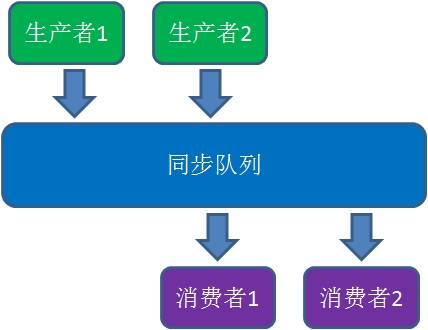

按照上面的流程进行代码实现，性能不高，原因如下：

1.涉及到同步锁。

2.涉及到线程阻塞状态和可运行状态之间的切换。

3.涉及到线程上下文的切换。

**以上涉及到的任何一点，都是非常耗费性能的操作。因此我们需要协程**

协程（Coroutines），是一种比线程更加轻量级的存在。正如一个进程可以拥有多个线程一样，一个线程也可以拥有多个协程。


通俗一点解释，协程的作用是在执行函数A时可以随时中断去执行函数B，然后中断函数B继续执行函数A（可以自由切换）。但这一过程并不是函数调用，这一整个过程看似像多线程，然而协程只有一个线程执行。


**那协程有什么优势呢？**

1.执行效率极高，因为子程序切换（函数）不是线程切换，由程序自身控制，没有切换线程的开销。所以与多线程相比，线程的数量越多，协程性能的优势越明显。


2.不需要多线程的锁机制，因为只有一个线程，也不存在同时写变量冲突，在控制共享资源时也不需要加锁，因此执行效率高很多。
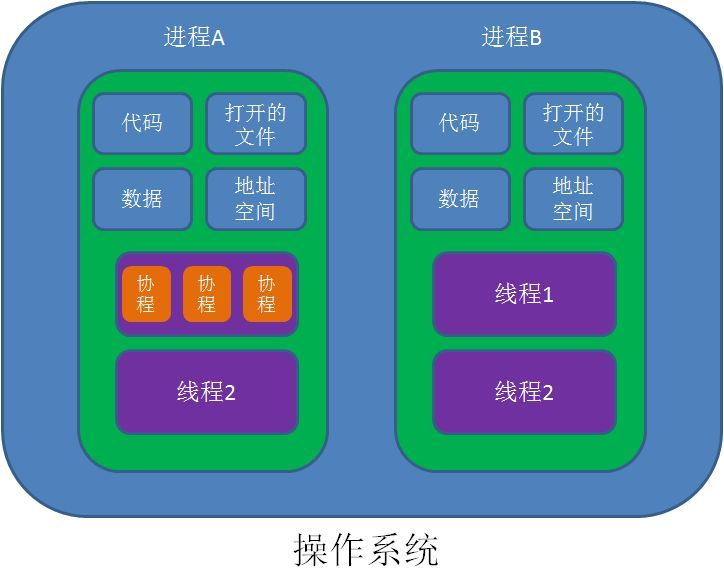


Python中的协程经历了很长的一段发展历程。其大概经历了如下三个阶段： 

最初的生成器变形yield/send 

引入@asyncio.coroutine和yield from * 

引入async/await关键字

上述是协程概念和优势的一些简介，感觉会比较抽象，Python2.x对协程的支持比较有限，生成器yield实现了一部分但不完全，gevent模块倒是有比较好的实现；Python3.4加入了asyncio模块，在Python3.5中又提供了async/await语法层面的支持，Python3.6中asyncio模块更加完善和稳定。接下来我们围绕这些内容详细阐述一下。

**Python2.x协程**


python2.x实现协程的方式有： yield + send 

**yield + send（利用生成器实现协程）**

我们通过“生产者-消费者”模型来看一下协程的应用，生产者生产消息后，直接通过yield跳转到消费者开始执行，待消费者执行完毕后，切换回生产者继续生产。

In [1]:
def consumer():
    r = ''
    while True:
        n = yield r
        if not n:
            return
        print('[CONSUMER]Consuming %s...' % n)
        r = '200 OK'

def producer(c):
    # 启动生成器
    c.send(None)
    n = 0
    while n < 5:
        n = n + 1
        print('[PRODUCER]Producing %s...' % n)
        r = c.send(n)
        print('[PRODUCER]Consumer return: %s' % r)
    c.close()

if __name__ == '__main__':
    c = consumer()
    producer(c)

[PRODUCER]Producing 1...
[CONSUMER]Consuming 1...
[PRODUCER]Consumer return: 200 OK
[PRODUCER]Producing 2...
[CONSUMER]Consuming 2...
[PRODUCER]Consumer return: 200 OK
[PRODUCER]Producing 3...
[CONSUMER]Consuming 3...
[PRODUCER]Consumer return: 200 OK
[PRODUCER]Producing 4...
[CONSUMER]Consuming 4...
[PRODUCER]Consumer return: 200 OK
[PRODUCER]Producing 5...
[CONSUMER]Consuming 5...
[PRODUCER]Consumer return: 200 OK


**send(msg)与next()的区别在于send可以传递参数给yield表达式，这时传递的参数会作为yield表达式的值，而yield的参数是返回给调用者的值。**换句话说，就是send可以强行修改上一个yield表达式的值。比如函数中有一个yield赋值a = yield 5，第一次迭代到这里会返回5，a还没有赋值。第二次迭代时，使用send(10)，那么就是强行修改yield 5表达式的值为10，本来是5的，结果a = 10。send(msg)与next()都有返回值，它们的返回值是当前迭代遇到yield时，yield后面表达式的值，其实就是当前迭代中yield后面的参数。第一次调用send时必须是send(None)，否则会报错，之所以为None是因为这时候还没有一个yield表达式可以用来赋值。上述例子运行之后输出结果如下：

**Python3.x协程**

除了Python2.x中协程的实现方式，Python3.x还提供了如下方式实现协程： asyncio + yield from (python3.4+) asyncio + async/await (python3.5+)

Python3.4以后引入了asyncio模块，可以很好的支持协程。

**asyncio + yield from**

asyncio是Python3.4版本引入的标准库，直接内置了对异步IO的支持。asyncio的异步操作，需要在coroutine中通过yield from完成。看如下代码（需要在Python3.4以后版本使用）：

@asyncio.coroutine把一个generator标记为coroutine类型，然后就把这个coroutine扔到EventLoop中执行。test()会首先打印出test_1，然后yield from语法可以让我们方便地调用另一个generator。由于asyncio.sleep()也是一个coroutine，所以线程不会等待asyncio.sleep()，而是直接中断并执行下一个消息循环。当asyncio.sleep()返回时，线程就可以从yield from拿到返回值（此处是None），然后接着执行下一行语句。把asyncio.sleep(1)看成是一个耗时1秒的IO操作，在此期间主线程并未等待，而是去执行EventLoop中其他可以执行的coroutine了，因此可以实现并发执行。

**asyncio + async/await**

为了简化并更好地标识异步IO，从Python3.5开始引入了新的语法async和await，可以让coroutine的代码更简洁易读。请注意，async和await是coroutine的新语法，使用新语法只需要做两步简单的替换：

1.把@asyncio.coroutine替换为async;2.把yield from替换为await
看如下代码（在Python3.5以上版本使用）：

In [7]:
import asyncio

async def test(i):
    print('test_1', i)
    await asyncio.sleep(1)
    print('test_2', i)

if __name__ == '__main__':
    loop = asyncio.get_event_loop()
    tasks = [test(i) for i in range(3)]
    loop.run_until_complete(asyncio.wait(tasks))

test_1 2
test_1 0
test_1 1
test_2 2
test_2 0
test_2 1
